In [1]:
import (
	"log"
	"os"
	"strconv"

    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg"
    "github.com/go-gota/gota/dataframe"
	"github.com/sajari/regression"
)

In [2]:
// pacf calculates the partial autocorrelation for a series
// at the given lag.
func pacf(x []float64, lag int) float64 {

	// Create a regresssion.Regression value needed to train
	// a model using github.com/sajari/regression.
	var r regression.Regression
	r.SetObserved("x")

	// Define the current lag and all of the intermediate lags.
	for i := 0; i < lag; i++ {
		r.SetVar(i, "x"+strconv.Itoa(i))
	}

	// Shift the series.
	xAdj := x[lag:len(x)]

	// Loop over the series creating the data set
	// for the regression.
	for i, xVal := range xAdj {

		// Loop over the intermediate lags to build up
		// our independent variables.
		laggedVariables := make([]float64, lag)
		for idx := 1; idx <= lag; idx++ {

			// Get the lagged series variables.
			laggedVariables[idx-1] = x[lag+i-idx]
		}

		// Add these points to the regression value.
		r.Train(regression.DataPoint(xVal, laggedVariables))
	}

	// Fit the regression.
	r.Run()

	return r.Coeff(lag)
}

In [3]:
func displayPlot(p *plot.Plot) {
    var buf bytes.Buffer
    c, err := p.WriterTo(10*vg.Inch, 4*vg.Inch, "png")
    if err != nil {
        panic(err)
    }
    
    if _, err := c.WriteTo(&buf); err != nil {
        panic(err)
    }

    gonbui.DisplayPNG(buf.Bytes())
}

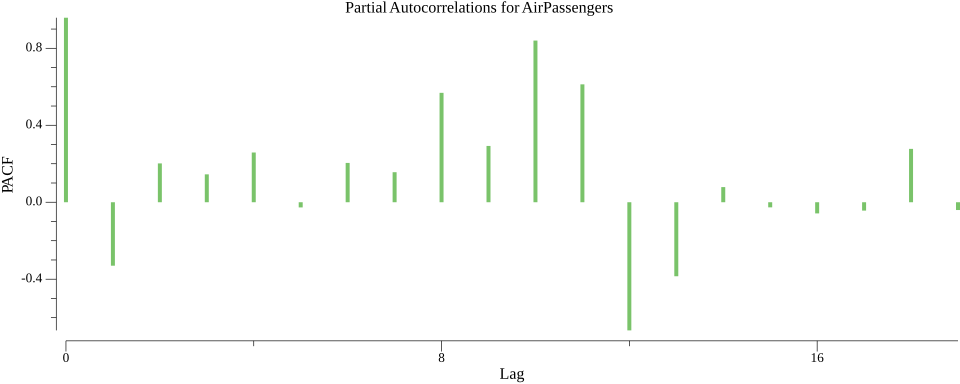

In [4]:
func main() {

	// Open the CSV file.
	passengersFile, err := os.Open("AirPassengers.csv")
	if err != nil {
		log.Fatal(err)
	}
	defer passengersFile.Close()

	// Create a dataframe from the CSV file.
	passengersDF := dataframe.ReadCSV(passengersFile)

	// Get the time and passengers as a slice of floats.
	passengers := passengersDF.Col("AirPassengers").Float()

	// Create a new plot, to plot our autocorrelations.
	p := plot.New()
	p.Title.Text = "Partial Autocorrelations for AirPassengers"
	p.X.Label.Text = "Lag"
	p.Y.Label.Text = "PACF"
	p.Y.Min = 15
	p.Y.Max = -1

	w := vg.Points(3)

	// Create the points for plotting.
	numLags := 20
	pts := make(plotter.Values, numLags)

	// Loop over various values of lag in the series.
	for i := 1; i <= numLags; i++ {

		// Calculate the partial autocorrelation.
		pts[i-1] = pacf(passengers, i)
	}

	// Add the points to the plot.
	bars, err := plotter.NewBarChart(pts, w)
	if err != nil {
		log.Fatal(err)
	}
	bars.LineStyle.Width = vg.Length(0)
	bars.Color = plotutil.Color(1)

	// Save the plot to a PNG file.
	p.Add(bars)

    displayPlot(p)
}